In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
# Functions for packing and unpacking images
def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc,1)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

In [88]:
# let's get our data
train = np.load('MNISTcwtrain1000.npy')
train = train.astype(float)/255
test = np.load('MNISTcwtest100.npy')
test = test.astype(float)/255

size = train.shape[0]
n_train = train.shape[1]
n_test = test.shape[1]

print '----MNIST dataset loaded----'
print 'Train data: %d x %d' %(size, n_train)
print 'Test data: %d x %d' %(size, n_test)

mean = np.mean(train, axis = 1)
cov = np.cov(train)

# assumes every column is a data point
def hideRightHalf(data):
    # make copies of data
    newData = data.copy()
    hiddenData = data.copy()
    
    # find the zeroing boundary point
    halfIdx = newData.shape[0]/2
    
    # zero out before and after the boundary point
    newData[halfIdx:, :] = 0
    hiddenData[0:halfIdx, :] = 0
    return newData, hiddenData
    
newTrain, hiddenTrain = hideRightHalf(train)
newTest, hiddenTest = hideRightHalf(test)

def Wstar(cov_x, cov_yx):
    if cov_x.any():
        cov_x_inv = np.linalg.pinv(cov_x)
    else:
        cov_x_inv = cov_x
    W = np.dot(cov_yx, cov_x_inv)
    return W

def mmseEstimator(x, u_x, u_y, cov_x, cov_yx):
    W = Wstar(cov_x, cov_yx)
    dist = x - u_x.reshape((u_x.shape[0]), 1)
    return np.dot(W, dist) + u_y.reshape((u_y.shape[0]), 1)

u_x = mean[0:size/2]
u_y = mean[size/2:]
cov_x = cov[0:size/2, 0:size/2]
cov_yx = cov[size/2:, 0:size/2]
Y_hat_train = mmseEstimator(newTrain[0:size/2, :], u_x, u_y, cov_x, cov_yx)
Y_hat_test = mmseEstimator(newTest[0:size/2, :], u_x, u_y, cov_x, cov_yx)

# calculate the mse of the training and test sets using affine estimator
diff_train = Y_hat_train - train[392:, :]
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = Y_hat_test - test[392:, :]
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Affine Estimator MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000
---- Affine Estimator MSE ----
Train data: 0.043065
Test data: 0.046884


In [116]:
# Load cnn predicted train and test data
predicted_train = np.load('predictedTrain.npy')
predicted_test = np.load('predictedTest.npy')

#print predicted_train[:, 1] == predicted_train[:, 9876]
#X_reduced = np.zeros((784, 1000))
#for i in range(10):
#    X_reduced[:, i*100:(i+1)*100] = train[:, i*1000:i*1000 + 100]

#predicted_train = predicted_train_pre[:, :1000]
#predicted_test = predicted_test[:, :1000]

# Images are normalized to [0,1]
size_predicted = predicted_train.shape[0]
n_train_predicted = predicted_train.shape[1]
n_test_predicted = predicted_test.shape[1]

print '-----Generated Datasets Loaded-----'
print 'Train Data: %d x %d' %(size_predicted,n_train_predicted)
print 'Test Data: %d x %d' %(size_predicted,n_test_predicted)

-----Generated Datasets Loaded-----
Train Data: 392 x 10000
Test Data: 392 x 1000


In [117]:
def getVectorMaskColumns(hiddenColumns):
    # create a mask
    maskImage = np.zeros((28, 28))
    maskImage[:, (28 - hiddenColumns):] = 1

    # get the relevant indices of the mask
    maskVec = packcw(maskImage, 28, 28)
    return maskVec

maskHalfHidden = getVectorMaskColumns(14)

In [118]:
restoredTrainImages = np.zeros((size, 10000))
restoredTestImages = np.zeros((size, n_test))

x_idx = np.where([maskHalfHidden == 0])[1]
y_idx = np.where([maskHalfHidden == 1])[1]

restoredTrainImages[x_idx] = train[x_idx, :]
restoredTestImages[x_idx] = test[x_idx, :]

restoredTrainImages[y_idx] = predicted_train
restoredTestImages[y_idx] = predicted_test

######################################################

restoredTrainImages_mmse = np.zeros((size, n_train))
restoredTestImages_mmse = np.zeros((size, n_test))

restoredTrainImages_mmse[x_idx] = train[x_idx, :]
restoredTestImages_mmse[x_idx] = test[x_idx, :]

restoredTrainImages_mmse[y_idx] = Y_hat_train
restoredTestImages_mmse[y_idx] = Y_hat_test

'''
restoredTestImages_mmse_reduced = np.zeros((784, 1000))
for i in range(10):
    restoredTestImages_mmse_reduced[:, i*100:(i+1)*100] = restoredTrainImages_mmse[:, i*1000:i*1000 + 100]
'''


'\nrestoredTestImages_mmse_reduced = np.zeros((784, 1000))\nfor i in range(10):\n    restoredTestImages_mmse_reduced[:, i*100:(i+1)*100] = restoredTrainImages_mmse[:, i*1000:i*1000 + 100]\n'

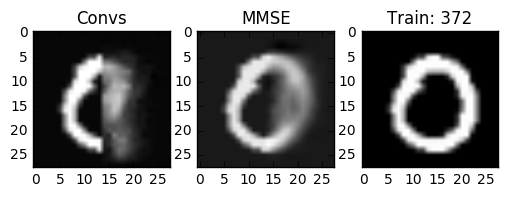

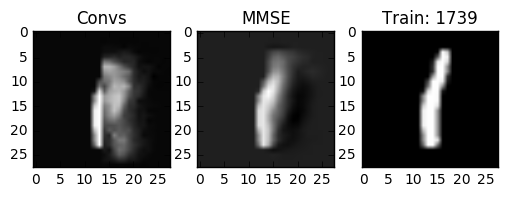

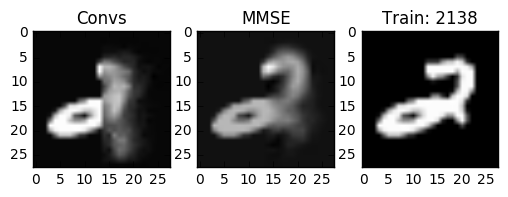

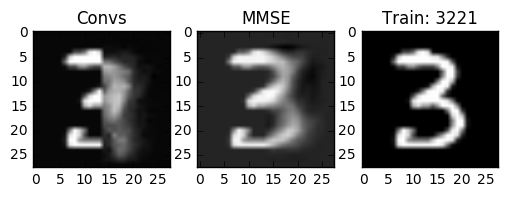

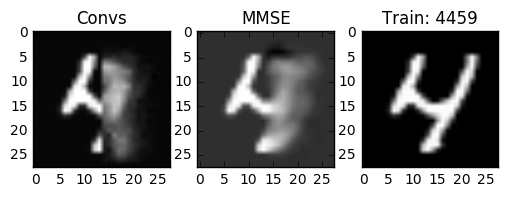

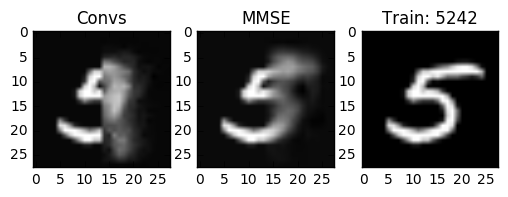

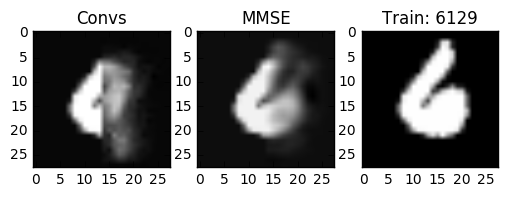

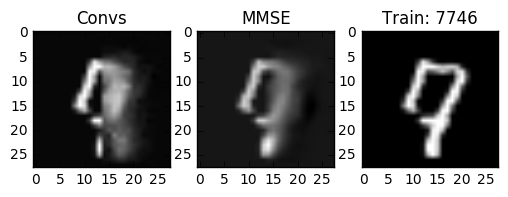

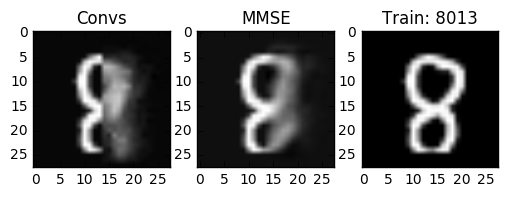

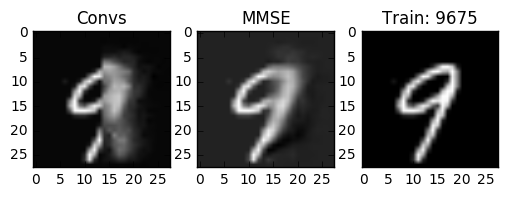

In [119]:
for i in range(10):  
    randomTrain = np.random.randint(i*1000, (i+1)*1000)
    #randomTrain = i*1000
    restoredTrain = restoredTrainImages[:, randomTrain]
    mmseTrain = restoredTrainImages_mmse[:, randomTrain]
    origTrain = train[:, randomTrain]

    imgMMSE_train = unpackcw(mmseTrain, 28, 28)
    imgOne = unpackcw(restoredTrain, 28, 28)
    imgOrigTrain = unpackcw(origTrain, 28, 28)

    plt.figure(i); 
    plt.subplot(1, 3, 1); plt.imshow(imgOne, cmap='gray'); plt.title('Convs')
    plt.subplot(1, 3, 2); plt.imshow(imgMMSE_train, cmap='gray'); plt.title('MMSE')
    plt.subplot(1, 3, 3); plt.imshow(imgOrigTrain, cmap='gray'); plt.title('Train: %d' %randomTrain)

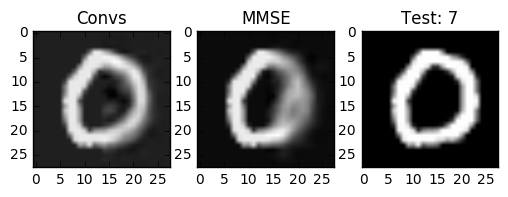

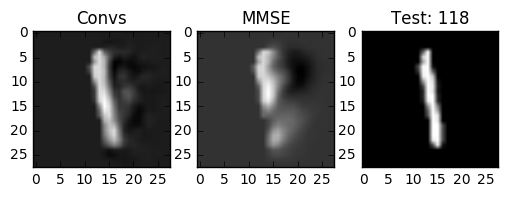

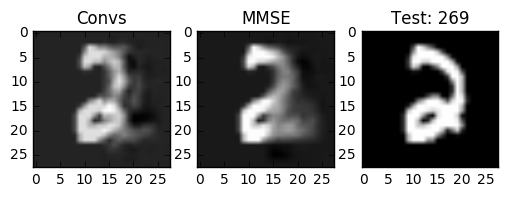

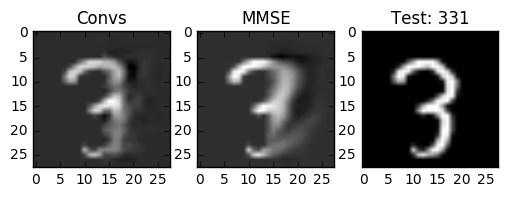

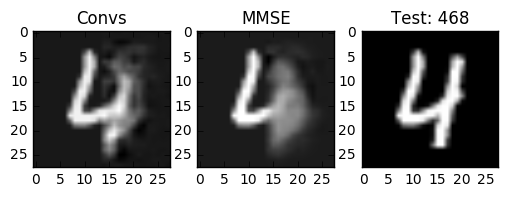

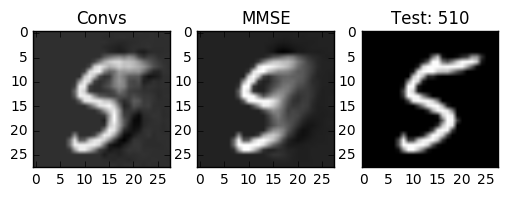

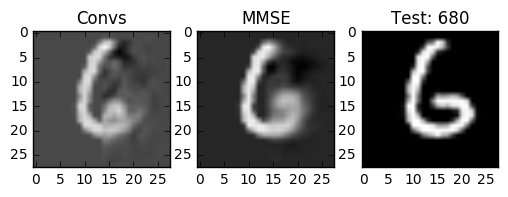

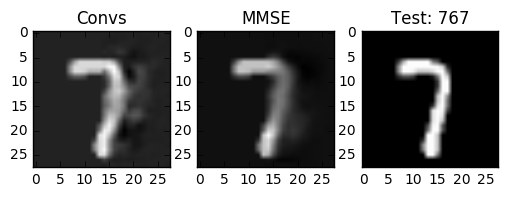

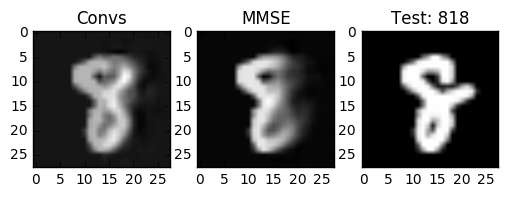

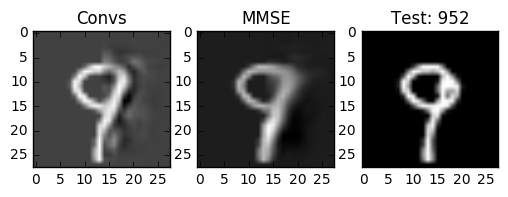

In [107]:
for i in range(10):
    randomTest = np.random.randint(i*100, (i+1)*100)

    mmseTest = restoredTestImages_mmse[:, randomTest]
    restoredTest = restoredTestImages[:, randomTest]
    origTest = test[:, randomTest]

    imgMMSE_test = unpackcw(mmseTest, 28, 28)
    imgTwo = unpackcw(restoredTest, 28, 28)
    imgOrigTest = unpackcw(origTest, 28, 28)

    plt.figure(i+10);
    plt.subplot(1, 3, 1); plt.imshow(imgTwo, cmap='gray'); plt.title('Convs')
    plt.subplot(1, 3, 2); plt.imshow(imgMMSE_test, cmap='gray'); plt.title('MMSE')
    plt.subplot(1, 3, 3); plt.imshow(imgOrigTest, cmap='gray'); plt.title('Test: %d' %randomTest)